In [1]:
import os
from pathlib import Path

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn

from tqdm.auto import tqdm,trange

from transformers import AdamW


BATCH_SIZE = 64

In [2]:
!rm -rf PoS-Tagging
!git clone https://github.com/Janluke0/PoS-Tagging/
os.chdir('PoS-Tagging')
out_dir = Path('/kaggle/working/')
out_dir.mkdir(exist_ok=True)

Cloning into 'PoS-Tagging'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 57 (delta 15), reused 57 (delta 15), pack-reused 0
Unpacking objects: 100% (57/57), 595.77 KiB | 1.84 MiB/s, done.


In [3]:
from model.transformers.italian import ItBERTCasedPos,ItBERTUncasedPos
from model import train_model
from dataset import TWITADS

## Common

this part should be adde to the repo, it's time to go lighting

In [4]:

def train_model(model, dl_train, dl_test, cuda=False, lr=0.001, epochs=10, show_plots=False, save_dir=None):
    loss_function = nn.NLLLoss()
    optimizer = AdamW(model.parameters(), lr=lr,weight_decay=0.01)
    
    if cuda:
        model = model.cuda()
    if save_dir is not None:
        save_dir.mkdir(exist_ok=True)
    
    losses = []
    accuracies = []
    best_acc = 0
    best_loss = float('inf')
    pbar = trange(epochs)
    for epoch in pbar:
        model.train()
        for sample in tqdm(iter(dl_train), desc=f"Training {epoch}° epoch", leave=False):
            x,m,y = sample['input_ids'],sample['attention_mask'], sample['labels']
            if cuda:
                x, m, y = x.cuda(), m.cuda(), y.cuda()
            optimizer.zero_grad()
            
            tag_scores =  model(input_ids=x,attention_mask=m)
            loss = loss_function(tag_scores.transpose(1, 2),y)

            loss.backward()
            optimizer.step()
            
        acc = []
        los = []
        ## evaluation
        model.eval()
        with torch.no_grad():
            for sample in tqdm(iter(dl_test), desc=f"Eval {epoch}° epoch", leave=False):
                x,m,y = sample['input_ids'],sample['attention_mask'], sample['labels']
                if cuda:
                    x, m, y = x.cuda(), m.cuda(), y.cuda()
                    
                tag_scores =  model(input_ids=x,attention_mask=m)
                if hasattr(tag_scores,'logits'):
                    tag_scores = tag_scores.logits
                    
                loss = loss_function(tag_scores.transpose(1, 2),y)
                los.append(loss.cpu().item())
                
                acc.append(((tag_scores.argmax(2))==y)[m==1].float())
            
        acc = torch.cat(acc).mean().item()
        los = np.array(los).mean()

        losses.append(los)
        accuracies.append(acc)
        #show epoch results
        pbar.set_description(f"Loss:{los}\tAccurancy:{acc}")
        if show_plots:
            plt.subplot(121)
            plt.title("Test loss")
            plt.plot(losses)

            plt.subplot(122)
            plt.title("Test accuracy")
            plt.plot(accuracies)
        if save_dir is not None and acc >= best_acc:
            torch.save(model.state_dict(),save_dir/f"model_best_acc.pth")
        if save_dir is not None and loss <= best_loss:
            torch.save(model.state_dict(),save_dir/f"model_best_loss.pth")
        
        best_acc = max(acc,best_acc)
        best_loss = max(los,best_loss)
    
    return losses,accuracies

def show_pred(model, ds, i):
    REVTAG = {v:k for k,v in ds._TAGS.items()}
    model.cpu()
    sample = ds.collate([ds[i]])
    x,m,y = sample['input_ids'],sample['attention_mask'], sample['labels']
    with torch.no_grad():
        pred = model(input_ids=x,attention_mask=m)
    tkns = ds.tokenizer.convert_ids_to_tokens(x[0,1:-1])
    return list(zip(tkns,[REVTAG[v.item()] for v in pred[0].argmax(1)[1:-1]],[REVTAG[v.item()] for v in y[0][1:-1]]))

In [5]:
def collate_fn(batch):
    input_ids, token_type_ids, attention_mask, labels = [[] for _ in range(4)] 
    for sample in batch:
        input_ids.append(sample['input_ids'])
        token_type_ids.append(sample['token_type_ids'])
        attention_mask.append(sample['attention_mask']) 
        labels.append(sample['labels'])
    return {
        'input_ids':pad_sequence(input_ids,batch_first=True),
        'token_type_ids': pad_sequence(token_type_ids,batch_first=True),
        'labels':pad_sequence(labels, padding_value=-100,batch_first=True),
        'attention_mask':pad_sequence(attention_mask,batch_first=True),
    }


In [6]:
def tokenize_and_align_labels(tokenizer, tokens, tags):
    tokens = list(tokens)
    tokenized_inputs = tokenizer(tokens, truncation=True, is_split_into_words=True)
    
    word_ids = tokenized_inputs.word_ids(batch_index=0)  # Map tokens to their respective word.
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:                            # Set the special tokens to -100
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:              # Only label the first token of a given word.
            label_ids.append(tags[word_idx])

    tokenized_inputs["labels"] = label_ids
    
    return {k:torch.tensor(v) for k,v in tokenized_inputs.items()}

## Cased model

In [7]:
cased_model = ItBERTCasedPos(23)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at

In [8]:
tokenizer = ItBERTCasedPos.tokenizer()
ds_train = TWITADS('resampled_train',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)
ds_val = TWITADS('resampled_validation',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

In [9]:
dl_train = DataLoader(ds_train, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
dl_val  = DataLoader(ds_val, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [10]:
?train_model

  0%|          | 0/100 [00:00<?, ?it/s]

Training 0° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 0° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 1° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 1° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 2° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 2° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 3° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 3° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 4° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 4° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 5° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 5° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 6° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 6° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 7° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 7° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 8° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 8° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 9° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 9° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 10° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 10° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 11° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 11° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 12° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 12° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 13° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 13° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 14° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 14° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 15° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 15° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 16° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 16° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 17° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 17° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 18° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 18° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 19° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 19° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 20° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 20° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 21° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 21° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 22° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 22° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 23° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 23° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 24° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 24° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 25° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 25° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 26° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 26° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 27° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 27° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 28° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 28° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 29° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 29° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 30° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 30° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 31° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 31° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 32° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 32° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 33° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 33° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 34° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 34° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 35° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 35° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 36° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 36° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 37° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 37° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 38° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 38° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 39° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 39° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 40° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 40° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 41° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 41° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 42° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 42° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 43° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 43° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 44° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 44° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 45° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 45° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 46° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 46° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 47° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 47° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 48° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 48° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 49° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 49° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 50° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 50° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 51° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 51° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 52° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 52° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 53° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 53° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 54° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 54° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 55° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 55° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 56° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 56° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 57° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 57° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 58° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 58° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 59° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 59° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 60° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 60° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 61° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 61° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 62° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 62° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 63° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 63° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 64° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 64° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 65° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 65° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 66° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 66° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 67° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 67° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 68° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 68° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 69° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 69° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 70° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 70° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 71° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 71° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 72° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 72° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 73° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 73° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 74° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 74° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 75° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 75° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 76° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 76° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 77° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 77° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 78° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 78° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 79° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 79° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 80° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 80° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 81° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 81° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 82° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 82° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 83° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 83° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 84° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 84° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 85° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 85° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 86° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 86° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 87° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 87° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 88° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 88° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 89° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 89° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 90° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 90° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 91° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 91° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 92° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 92° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 93° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 93° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 94° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 94° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 95° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 95° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 96° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 96° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 97° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 97° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 98° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 98° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 99° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 99° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

([1.8130196571350097,
  1.6979915976524353,
  1.671607542037964,
  1.6579473495483399,
  1.6499605894088745,
  1.6468056559562683,
  1.6420766115188599,
  1.6416708827018738,
  1.6407026648521423,
  1.6388348460197448,
  1.6384066224098206,
  1.6431079983711243,
  1.641774797439575,
  1.6432533502578734,
  1.6440528988838197,
  1.646860945224762,
  1.651805865764618,
  1.646846842765808,
  1.6522601008415223,
  1.6513084769248962,
  1.653838562965393,
  1.6514398097991942,
  1.6545713543891907,
  1.6514313459396361,
  1.6569684028625489,
  1.6531487226486206,
  1.6598397016525268,
  1.6610154271125794,
  1.6614040374755858,
  1.6599397659301758,
  1.662954044342041,
  1.665926957130432,
  1.6644437432289123,
  1.661346936225891,
  1.6636237978935242,
  1.6665120601654053,
  1.665195059776306,
  1.6674719095230102,
  1.6650674700737,
  1.6638257265090943,
  1.6658761620521545,
  1.6654563546180725,
  1.6663202166557312,
  1.6658744812011719,
  1.6629128932952881,
  1.6621149063110352,
 

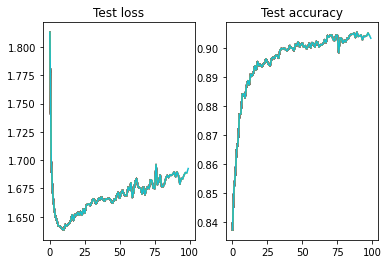

In [11]:
torch.manual_seed(42)
train_model(cased_model,dl_train,dl_val,cuda=torch.cuda.is_available(), lr=2e-5, epochs=100, show_plots=True, save_dir=out_dir/"cased_model")

## Uncased model

In [12]:
uncased_model = ItBERTUncasedPos(23)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-italian-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

In [13]:
tokenizer = ItBERTUncasedPos.tokenizer()
ds_train = TWITADS('resampled_train',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)
ds_val = TWITADS('resampled_validation',
                 lambda w:[w], 
                 transform=lambda a,b: tokenize_and_align_labels(tokenizer,a,b)
)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

In [14]:
dl_train = DataLoader(ds_train, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
dl_val  = DataLoader(ds_val, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

Training 0° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 0° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 1° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 1° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 2° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 2° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 3° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 3° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 4° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 4° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 5° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 5° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 6° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 6° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 7° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 7° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 8° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 8° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 9° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 9° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 10° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 10° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 11° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 11° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 12° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 12° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 13° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 13° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 14° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 14° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 15° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 15° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 16° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 16° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 17° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 17° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 18° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 18° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 19° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 19° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 20° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 20° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 21° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 21° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 22° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 22° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 23° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 23° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 24° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 24° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 25° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 25° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 26° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 26° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 27° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 27° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 28° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 28° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 29° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 29° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 30° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 30° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 31° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 31° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 32° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 32° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 33° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 33° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 34° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 34° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 35° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 35° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 36° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 36° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 37° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 37° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 38° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 38° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 39° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 39° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 40° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 40° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 41° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 41° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 42° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 42° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 43° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 43° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 44° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 44° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 45° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 45° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 46° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 46° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 47° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 47° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 48° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 48° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 49° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 49° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 50° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 50° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 51° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 51° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 52° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 52° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 53° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 53° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 54° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 54° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 55° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 55° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 56° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 56° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 57° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 57° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 58° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 58° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 59° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 59° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 60° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 60° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 61° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 61° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 62° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 62° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 63° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 63° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 64° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 64° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 65° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 65° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 66° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 66° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 67° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 67° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 68° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 68° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 69° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 69° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 70° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 70° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 71° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 71° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 72° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 72° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 73° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 73° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 74° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 74° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 75° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 75° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 76° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 76° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 77° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 77° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 78° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 78° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 79° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 79° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 80° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 80° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 81° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 81° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 82° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 82° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 83° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 83° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 84° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 84° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 85° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 85° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 86° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 86° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 87° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 87° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 88° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 88° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 89° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 89° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 90° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 90° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 91° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 91° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 92° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 92° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 93° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 93° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 94° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 94° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 95° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 95° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 96° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 96° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 97° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 97° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 98° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 98° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training 99° epoch:   0%|          | 0/91 [00:00<?, ?it/s]

Eval 99° epoch:   0%|          | 0/10 [00:00<?, ?it/s]

([1.6894435286521912,
  1.600848376750946,
  1.5762154579162597,
  1.563267183303833,
  1.5622152447700501,
  1.5593457221984863,
  1.5553905487060546,
  1.5560644626617433,
  1.5582425951957704,
  1.5549959540367126,
  1.5536412239074706,
  1.5596275329589844,
  1.5601265549659729,
  1.558625626564026,
  1.560780692100525,
  1.5626933336257935,
  1.5633742451667785,
  1.5646281003952027,
  1.5694751501083375,
  1.5714045524597169,
  1.570802426338196,
  1.5748461723327636,
  1.5718544602394104,
  1.5759273290634155,
  1.5755036115646361,
  1.573784554004669,
  1.5748224973678588,
  1.5772189497947693,
  1.5796263694763184,
  1.5847679376602173,
  1.5814448356628419,
  1.5825689911842347,
  1.582095241546631,
  1.5793493390083313,
  1.583695363998413,
  1.583694589138031,
  1.5860363125801087,
  1.5883968234062196,
  1.5834315061569213,
  1.5839833855628966,
  1.5922879695892334,
  1.5880231022834779,
  1.590298855304718,
  1.5862347960472107,
  1.5938259482383728,
  1.5898569107055665

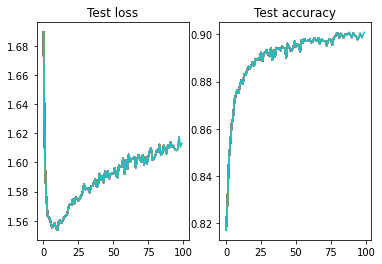

In [15]:
torch.manual_seed(42)
train_model(uncased_model,dl_train,dl_val,cuda=torch.cuda.is_available(), lr=2e-5, epochs=100, show_plots=True,save_dir=out_dir/"uncased_model")

In [16]:
#remove repo from saved output
!rm -rf /kagle/working/PoS-Tagging

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
